# Data Collection and Cleaning

## Downloaded Dataset



In [907]:
import numpy as np
import pandas as pd
import csv
import re 
import pprint as p
import json
def data_parser(filename):
    mlbteams = "Baltimore Orioles	Baltimore, Maryland\
	Boston Red Sox Boston, Massachusetts\
	New York Yankees New York City, New York\
	Tampa Bay Rays Florida\
	Chicago White Sox Chicago, Illinois\
	Cleveland Indians Cleveland, Ohio\
	Detroit Tigers Detroit, Michigan\
	Kansas City Royals Kansas City, Missouri\
	Minnesota Twins	Minneapolis, Minnesota\
	Houston Astros Houston, Texas\
	Los Angeles Angels California\
	Oakland Athletics Oakland, California\
	Seattle Mariners Seattle, Washington\
	Texas Rangers Arlington, Texas\
	Atlanta Braves Atlanta, Georgia\
	Miami Marlins Miami, Florida\
	New York Mets New York City, New York\
	Philadelphia Phillies Philadelphia, Pennsylvania\
	Washington Nationals Washington, D.C.\
	Chicago Cubs Chicago, Illinois\
	Cincinnati Reds Cincinnati, Ohio\
	Milwaukee Brewers Milwaukee, Wisconsin\
	Pittsburgh Pirates Pittsburgh, Pennsylvania\
	St. Louis Cardinals St. Louis, Missouri\
	Arizona Diamondbacks Phoenix, Arizona\
	Colorado Rockies Denver, CO\
	Los Angeles Dodgers Los Angeles, CA\
	San Diego Padres San Diego, California\
	San Francisco Giants San Francisco, California"
    # The string above represents all MLB teams and their home city

    df['mlb_city'] = np.where(df['city'].apply(lambda a: a in mlbteams), 'MLB TEAM', (df['city'])) #creates column with value that indicates whether the city
#     df['statepop'] = df.groupby('state_id')['population'].sum()                                                                                        #is home to an MLB team within the US.

    df2 = df[(df['mlb_city'] == "MLB TEAM") & (df['population'] > 100000)] #Gets rows of all cities that are home to MLB teams and not duplicate data with inaccurate population below 500,000
    df2 = pd.DataFrame(df2)
    df2['area size'] = df2['population']/df2['density']
    df2 = (df2[['city','state_id','population','lat','lng','density','area size']])
    df2.to_csv('mlb_cities_population.csv', index = False)

    return df2
    

def csv_parser(filename):
	return pd.read_csv(filename)

def export_excel(df2, filename, sheetname):
	writer = pd.ExcelWriter(filename)
	df2.to_excel(writer, sheet_name = sheetname)
	writer.save()

df = csv_parser("uscities.csv")
dfedit = data_parser('uscities.csv')
nonmlbdf = df[(df['mlb_city'] != "MLB TEAM") & (df['population'] > 400000)]
statepop = df.groupby('state_id')['population'].sum().reset_index()
# print(df2.sort_values('population', ascending = False)[0:10])
print(df2)
print(statepop)
print(nonmlbdf)
print((dfedit))

              city state_id  population
0         New York       NY    18713220
1      Los Angeles       CA    12750807
2          Chicago       IL     8604203
3            Miami       FL     6445545
5     Philadelphia       PA     5649300
6          Houston       TX     5464251
7          Atlanta       GA     5449398
8       Washington       DC     5379184
9           Boston       MA     4688346
10         Phoenix       AZ     4219697
11         Seattle       WA     3789215
12   San Francisco       CA     3592294
13         Detroit       MI     3506126
14       San Diego       CA     3220118
15     Minneapolis       MN     2977172
16           Tampa       FL     2908063
17          Denver       CO     2876625
21       Baltimore       MD     2106068
25       St. Louis       MO     2024074
29       Cleveland       OH     1710093
30      Pittsburgh       PA     1703266
32      Cincinnati       OH     1662691
33     Kansas City       MO     1636715
40       Milwaukee       WI     1365787


## Web Collection \#1


In [908]:
import requests
from bs4 import BeautifulSoup
import re
import pprint as p 
import json
import pandas as pd
def web_parser1(filename):
    url = 'https://www.baseball-almanac.com/ws/wsmenu.shtml'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.content, "html.parser")
    table = str(soup.find_all('tr'))
#     pattern = '\d{4}\s[A-Z][a-z]+\s[a-zA-Z]+'
    pattern = '\d{4}'
    scraped = re.findall(pattern, table)
    year = []
    for i in scraped: #This for loop is because it put the world series twice for every year
        if i not in year and ('1904' not in i) and ('1994' not in i):
            year.append(i) #World Series did not happen in 1904 and 1944

    losers = re.findall('">([A-Z].*?[a-z])<br/>', table)
    winners = re.findall('<strong>([A-Z].*?)<', table)
    winlose = list(zip(winners,losers))
    odict = {'Year': ('Winner','Loser')}
    odict = {year[i]:winlose[i] for i in range(len(year))}
    with open(filename, 'w') as f:
        json.dump(odict, f)
    fdict = pd.DataFrame({'Year':year,'Wins':winners, 'Losses':losers})
    return (fdict)




############ Function Call ############
print(web_parser1('World Series Matchups.json'))
bargraph = web_parser1('World Series Matchups.json')

     Year                  Wins                  Losses
0    1903      Boston Americans      Pittsburgh Pirates
1    1905       New York Giants  Philadelphia Athletics
2    1906     Chicago White Sox            Chicago Cubs
3    1907          Chicago Cubs          Detroit Tigers
4    1908          Chicago Cubs          Detroit Tigers
..    ...                   ...                     ...
112  2017        Houston Astros     Los Angeles Dodgers
113  2018        Boston Red Sox     Los Angeles Dodgers
114  2019  Washington Nationals          Houston Astros
115  2020   Los Angeles Dodgers          Tampa Bay Rays
116  2021        Atlanta Braves          Houston Astros

[117 rows x 3 columns]


## Web Collection #2

In [909]:
import requests
import json
import pprint as p
resp = requests.get("http://statsapi.mlb.com/api/v1/teams")
jdict = resp.json()
def web_parser2(filename):
    #return jdict['teams'][0]
    odict = {}
    for t in jdict['teams']:
        if 'id' in t['league'].keys():
            if t['sport']['id'] == 1:
                td = {}
                odict[t['name']] = td
                td['Spring League'] = 'Cactus League' if t['springLeague']['id'] == 114 else 'Grapefruit League'
                td['Venue'] = t['venue']['name']
                td['City'] = t['locationName']
                td['Established'] = t['firstYearOfPlay']
                td['League'] = t['league']['name']
                td['Division'] = (t['division']['name']).split()[2]
                td['Minor League Teams'] = {}
    return (odict)
    with open(filename, 'w') as f:
        json.dump(odict, f)


############ Function Call ############
web_parser2('mlbdict.json')

{'Los Angeles Angels': {'Spring League': 'Cactus League',
  'Venue': 'Angel Stadium',
  'City': 'Anaheim',
  'Established': '1961',
  'League': 'American League',
  'Division': 'West',
  'Minor League Teams': {}},
 'Arizona Diamondbacks': {'Spring League': 'Cactus League',
  'Venue': 'Chase Field',
  'City': 'Phoenix',
  'Established': '1996',
  'League': 'National League',
  'Division': 'West',
  'Minor League Teams': {}},
 'Baltimore Orioles': {'Spring League': 'Grapefruit League',
  'Venue': 'Oriole Park at Camden Yards',
  'City': 'Baltimore',
  'Established': '1901',
  'League': 'American League',
  'Division': 'East',
  'Minor League Teams': {}},
 'Boston Red Sox': {'Spring League': 'Grapefruit League',
  'Venue': 'Fenway Park',
  'City': 'Boston',
  'Established': '1901',
  'League': 'American League',
  'Division': 'East',
  'Minor League Teams': {}},
 'Chicago Cubs': {'Spring League': 'Cactus League',
  'Venue': 'Wrigley Field',
  'City': 'Chicago',
  'Established': '1874',
  

In [910]:
import requests
import json
import pprint as p
from bs4 import BeautifulSoup
import re
def extra_source1(filename):
    url = 'https://www.fueledbysports.com/mlb-payrolls/'
    res = requests.get(url)
    src_code = res.text
    soup = BeautifulSoup(src_code, "html.parser")
    tbls = soup.find_all('tbody')
    tbList = []
    tbdict = {}
    curnum = 0
    finaldict = {}
    for t in tbls:
        splitt = t.find_all("td")
        csr = [item.text for item in splitt]
        tbList.append(csr)
    for y in range(2021, 2009, -1):
        tbdict[y] = tbList[curnum]
        curnum += 1
    for y in range(2019, 2022):
        del tbdict[y][::3]
    for y in range(2010, 2019):
        newList = []
        for t in tbdict[y]:
            if t[0].isdigit():
                newList.append(t[3:].strip())
            else:
                newList.append(t.strip())
        tbdict[y] = newList
    for y in range(2010,2022):
        finaldict[y] = dict(zip(tbdict[y][::2], tbdict[y][1::2]))
    with open(filename, 'w') as f:
        json.dump(finaldict, f)
    return finaldict

############ Function Call ############
finaldict = (extra_source1('mlbpayrolls.json'))
p.pprint(finaldict)

{2010: {'Arizona': '$60,718,167',
        'Atlanta*': '$84,423,667',
        'Baltimore': '$81,612,500',
        'Boston': '$162,747,333',
        'Chicago Cubs': '$146,859,000',
        'Chicago White Sox': '$108,273,197',
        'Cincinnati*': '$72,386,544',
        'Cleveland': '$61,203,967',
        'Colorado': '$84,227,000',
        'Detroit': '$122,864,929',
        'Florida': '$55,641,500',
        'Houston': '$92,355,500',
        'Kansas City': '$72,267,710',
        'L.A.\xa0Angels': '$105,013,667',
        'L.A.\xa0Dodgers': '$94,945,517',
        'Milwaukee': '$81,108,279',
        'Minnesota*': '$97,559,167',
        'N.Y. Mets': '$132,701,445',
        'N.Y. Yankees*': '$206,333,389',
        'Oakland': '$51,654,900',
        'Philadelphia*': '$141,927,381',
        'Pittsburgh': '$34,943,000',
        'San Diego': '$37,799,300',
        'San Francisco*': '$97,828,833',
        'Seattle': '$98,376,667',
        'St. Louis': '$93,540,753',
        'Tampa Bay*': '$71,923,4

## Data Sources

*   Downloaded Dataset Source: https://simplemaps.com/data/us-cities
*   Web Collection #1 Source: https://www.baseball-almanac.com/ws/wsmenu.shtml 
*   Web Collection #2 Source: https://statsapi.mlb.com/api/v1/standings?leagueId=103&season=2021&standingsTypes=regularSeason 
*   Additional Source: https://www.fueledbysports.com/mlb-payrolls/



# Data Analysis
For the Data Analysis section, you are required to utilize your data to complete the following:

*   Create at least 5 insights
*   Generate at least 3 data visualizations
*   Export aggregated data to at least 1 summary file 

Create a function for each of the following sections mentioned above. Do not forget to fill out the explanation section for each function. 

Make sure your data analysis is not too simple. Performing complex aggregation and using modules not taught in class shows effort, which will increase the chance of receiving full credit. 

# Graphical User Interface (GUI) Implementation
If you decide to create a GUI for Phase II, please create a separate Python file (.py) to build your GUI. You must submit both the completed PhaseII.ipynb and your Python GUI file.

## Insights

In [911]:
import pandas as pd
def insight1():
    wdict = pd.DataFrame(bargraph['Wins'].value_counts()).reset_index()
    ldict = pd.DataFrame(bargraph['Losses'].value_counts()).reset_index()
    wdict = wdict.rename(columns={'index': 'Team'})
    ldict = ldict.rename(columns={'index':'Team'})
    
    new = wdict.merge(ldict, left_on='Team', right_on = 'Team')
    new.reset_index()
    new['Total World Series'] = new['Wins'] + new['Losses']
    new['% Wins'] = round(((new['Wins'] / new['Total World Series'])* 100),1)
    
    topteams = (new.sort_values('Total World Series', ascending = False))
    topstr = 'The top ten teams by appearance in World Series: '
    
    for i in range(0,12):
        topstr += '\n' + str(topteams['Team'][i])# + ' (' + str(topteams['% Wins'][i]) + '% Win Ratio), '
    topstr = topstr + '.'
#     print(topstr)
    return (topstr)
############ Function Call ############

topstr = (insight1())
print(topstr)
df3 = (df2.sort_values('population', ascending = False)[0:10])
count = 0
for i in df3['city']:
    if i in topstr:
        count += 1
print(f'{count} of the top 10 MLB Teams are also in the top 10 highest populated U.S. Cities.')

The top ten teams by appearance in World Series: 
New York Yankees
St. Louis Cardinals
Boston Red Sox
Los Angeles Dodgers
New York Giants
Pittsburgh Pirates
Philadelphia Athletics
Cincinnati Reds
Detroit Tigers
Oakland Athletics
Chicago White Sox
Chicago Cubs.
5 of the top 10 MLB Teams are also in the top 10 highest populated U.S. Cities.


### Insight 1 Explanation

Question: Which MLB teams have the most appearences in the World Series? Is this revelevant to city population size? 

To get a better understanding on if population factors into having a "World Series Quality Team", we wanted to frame our dataset of every World Series matchup to gather the top ten teams in terms of appearances in the World Series. From here, the data on U.S city populations was manipulated to present the top ten highest populated cities. When comparing the two sets of data as seen above, we discovered that 5 of the top 10 ten teams in appearance reside in a city that is ranked top 10 in U.S population. What proved to be interesting about this is that all 10 of the highest populated U.S. cities have an MLB Team, so 50% of the top teams reside in top population cities, while the other 50% reside in lower population cities. Since the results proved to be a 50-50 in terms of appearance in World Series to Population size, it seems the size of the city has not had a significant effect on the success of an MLB Team. Initially, we thought this to be counter-intuitive because we assumed that cities with high population have a larger economic market, thus having an MLB Team with more money to be able to have top players, but this proved to be false. 

In [912]:
def insight2():
    wdict = pd.DataFrame(bargraph['Wins'].value_counts()).reset_index()
    ldict = pd.DataFrame(bargraph['Losses'].value_counts()).reset_index()
    
    wdict = wdict.rename(columns={'index': 'Team'})
    ldict = ldict.rename(columns={'index':'Team'})
    
    new = wdict.merge(ldict, left_on='Team', right_on = 'Team')
    new.reset_index()
    new['Total World Series'] = new['Wins'] + new['Losses']
    new['% Wins'] = round(((new['Wins'] / new['Total World Series'])* 100),1)
    
    print('The average time that a team wins is ' + str(round(new['% Wins'].mean(),1)) + '%, while the median value is ' 
          + str(new['% Wins'].median()) + '%.')
    
    topteams = (new.sort_values('Total World Series', ascending = False))
    topteams = topteams[0:5]
    topteamsstr = 'The top five teams by appearances are: '
    
    for i in range(0,5):
#         print(i)
        topteamsstr += f'\n{i+1}. ' + str(topteams['Team'][i])
    print(topteamsstr)
    
    twinratio = new.sort_values('% Wins', ascending = False)
    twinratiotop = twinratio[0:5].reset_index()
#     print(twinratiotop['Team'])
    twinratiostr = 'While the top five teams by Win Ratio are: '
    
    for i in range(0,5):
        twinratiostr += f'\n{i+1}. ' + str(twinratiotop['Team'][i] + ' (' + str(twinratiotop['% Wins'][i]) +'% Win Ratio)')
    print(twinratiostr)
#     return new




############ Function Call ############
insight2()

The average time that a team wins is 47.3%, while the median value is 50.0%.
The top five teams by appearances are: 
1. New York Yankees
2. St. Louis Cardinals
3. Boston Red Sox
4. Los Angeles Dodgers
5. New York Giants
While the top five teams by Win Ratio are: 
1. Pittsburgh Pirates (71.4% Win Ratio)
2. New York Yankees (67.5% Win Ratio)
3. Boston Red Sox (66.7% Win Ratio)
4. Minnesota Twins (66.7% Win Ratio)
5. Oakland Athletics (66.7% Win Ratio)


### Insight 2 Explanation

Of the MLB Teams that make it to the World Series, are the teams with the most series played also the teams with the highest ratio of series won vs. series played? 

To gather insight into how well the teams that consistently make it to the World Series perform, we compared the data from the top five teams by appearances vs. top five teams by win ratio. From this we gathered that the only two teams (Yankees and Red Sox) are consistent in both top appearances and top win ratio in the World Series. Since only 25 teams have been to the World Series, it is relatively easy for a team or two to skew the data (Yankees and Pirates), however, we noticed that the median value of win ration to be exactly 50% - which indicated the data had a close-to-normal distribution. Because it's possible for a team to win a World Series and that be the only World Series appearance they have and the result of the data above, we've determined that how often a team wins vs. making it to the Series is not a significant contribution to what makes the World Series winner.  

In [913]:
import folium
import pandas as pd
import json
from folium import plugins

def insight3():
    finaldicts = pd.DataFrame(finaldict)
    finaldicts = finaldicts.reset_index()
    finaldicts = finaldicts.rename(columns={'index': 'Team'})
#     return finaldicts
    newdict = pd.DataFrame()
    newl = []
    yearl = []
    winners = []
    losers = []
    
    final_dictz = pd.DataFrame()

    
    for y in range(2010,2022):
        newdict = finaldicts[y].dropna()
        newdict = newdict.replace('\D','',regex = True).astype(int)

        salaries = np.array(finaldicts[y])
        win_salary = 0;
        loser_salary = 0;
        average = int(newdict.mean())
        
        winner = bargraph['Wins'][y-1905]
        loser = bargraph['Losses'][y-1905]
        
        comp = winner.split()[0]
        loser_comp = loser.split()[0]
        for i, team in enumerate(finaldicts['Team']):
            if comp == team.split()[0] and str(salaries[i]).lower() != "nan":
                win_salary = salaries[i]               
            if team.split()[0][-1] == "*" and comp == team.split()[0][0:-1] and str(salaries[i]).lower() != "nan":
                win_salary = salaries[i]             
            if (team.split()[0][-1] == "*" and loser_comp == team.split()[0][0:-1] or loser_comp == team.split()[0]) and str(salaries[i]).lower() != "nan":
                loser_salary = salaries[i]           
            # New York Edge Case
            if team.split()[0] == "N.Y." and loser_comp == "New" and str(salaries[i]).lower() != "nan":
                loser_salary = salaries[i]        
#         
        final_dictz = final_dictz.append({'Year':str(y), 'Average Salary': average,
                                          'Winner': winner, "Winner Salary" : win_salary,
                                          "Loser" : loser,  "Loser Salary" : loser_salary,}, ignore_index=True)
    final_dictz["Winner Salary"] = final_dictz["Winner Salary"].replace('\D','',regex = True).astype(int)
    final_dictz["Loser Salary"] = final_dictz["Loser Salary"].replace('\D','',regex = True).astype(int)
    
    final_dictz["Winner Salary > Avg"] = final_dictz["Winner Salary"] > final_dictz["Average Salary"]
    final_dictz["Loser Salary > Avg "] = final_dictz["Loser Salary"] > final_dictz["Average Salary"]
    final_dictz['Winner > Loser Salary'] = final_dictz['Winner Salary'] > final_dictz['Loser Salary']
    compareavg = final_dictz

    return compareavg

############ Function Call ############
insight3()

,Year,Average Salary,Winner,Winner Salary,Loser,Loser Salary,Winner Salary > Avg,Loser Salary > Avg,Winner > Loser Salary
0,2010,91020056.0,San Francisco Giants,37799300,Texas Rangers,55250545,False,False,False
1,2011,92991718.0,St. Louis Cardinals,105433572,Texas Rangers,92299265,True,False,True
2,2012,97678115.0,San Francisco Giants,55871900,Detroit Tigers,132276000,False,True,False
3,2013,106252269.0,Boston Red Sox,158967286,St. Louis Cardinals,116702085,True,True,True
4,2014,115132013.0,San Francisco Giants,90094196,Kansas City Royals,92034345,False,False,False
5,2015,124707037.0,Kansas City Royals,113618650,New York Mets,101409244,False,False,True
6,2016,131261429.0,Chicago Cubs,167444167,Cleveland Indians,98006899,True,False,True
7,2017,137790903.0,Houston Astros,124343900,Los Angeles Dodgers,160375333,False,True,False
8,2018,137912866.0,Boston Red Sox,235650000,Los Angeles Dodgers,175100000,True,True,True
9,2019,127151001.0,Washington Nationals,181400409,Houston Astros,177443329,True,True,True


### Insight 3 Explanation

Question: Does a Team's salary correlate to them getting to and winning the World Series? 

Through scraping and merging data, we were able to compare the World Series Champion Team's salary to the average team, and it's oppenent -- this process was repeated for the losing team in the Series as well. We discovered that only 58% of the Winner's from 2010-2021 had a higher salary than the League average for the year. 58% of the winners had a higher salary than the team they beat in the World Series from 2010-2021. Based on these findings, it seems that the salary of the team does not have a significant effect on getting a team to the World Series and also does not have a significant effect on whether or not a team beats their opponent in the series. 

In [914]:
def insight4():
    wdict = pd.DataFrame(bargraph['Wins'].value_counts()).reset_index()
    ldict = pd.DataFrame(bargraph['Losses'].value_counts()).reset_index()
    wdict = wdict.rename(columns={'index': 'Team'})
    ldict = ldict.rename(columns={'index':'Team'})
    
    new = wdict.merge(ldict, left_on='Team', right_on = 'Team')
    new.reset_index()
    new['Total World Series'] = new['Wins'] + new['Losses']
    
    new.reset_index()
#     return new

    new['% Wins'] = round(((new['Wins'] / new['Total World Series'])* 100),1)
    estab_dict = pd.DataFrame(info_dict)
    estab_dict = estab_dict.transpose()
    estab_dict = estab_dict.reset_index()
    estab_dict = estab_dict.rename(columns={'index':'Team'})
    estab_league = pd.merge(estab_dict, new, on='Team', how='outer')
    estab_league = estab_league[0:30]
    del estab_league['Minor League Teams']
    estab_league = estab_league.fillna(0)
    
    
    national_count_wins = 0
    american_count_wins = 0
    american_count_app = 0
    national_count_app = 0
    
    for i, sleague in enumerate(estab_league['League']):
        
        if sleague == 'American League':
            american_count_wins += estab_league['Wins'][i]
            american_count_app += estab_league['Total World Series'][i]
            
        if sleague == 'National League':
            national_count_wins += estab_league['Wins'][i]
            national_count_app += estab_league['Total World Series'][i]
            
    print('American League Wins: ' + str(american_count_wins))
    print('American League Total: ' + str(american_count_app))
    print('National Wins: ' + str(national_count_wins))
    print('National Total: ' + str(national_count_app))    
    
    estab_league = estab_league[['Team','City','League','Wins','Losses','Total World Series','% Wins']]
    
    return estab_league

############ Function Call ############
insight4()

American League Wins: 54.0
American League Total: 91.0
National Wins: 39.0
National Total: 82.0


,Team,City,League,Wins,Losses,Total World Series,% Wins
0,Los Angeles Angels,Anaheim,American League,0.0,0.0,0.0,0.0
1,Arizona Diamondbacks,Phoenix,National League,0.0,0.0,0.0,0.0
2,Baltimore Orioles,Baltimore,American League,3.0,3.0,6.0,50.0
3,Boston Red Sox,Boston,American League,8.0,4.0,12.0,66.7
4,Chicago Cubs,Chicago,National League,3.0,8.0,11.0,27.3
5,Cincinnati Reds,Cincinnati,National League,5.0,4.0,9.0,55.6
6,Cleveland Guardians,Cleveland,American League,0.0,0.0,0.0,0.0
7,Colorado Rockies,Denver,National League,0.0,0.0,0.0,0.0
8,Detroit Tigers,Detroit,American League,4.0,7.0,11.0,36.4
9,Houston Astros,Houston,American League,1.0,3.0,4.0,25.0


### Insight 4 Explanation

Does being in the American vs. National League affect chance of winning the World Series?

Since the American and National League had differenet rules for many years, we thought it was worth looking into to see if being a member of either of these leagues has a benefit over the other to get to and win the World Series. We found that the American League is slightly ahead of the National League with wins from current U.S. teams. The American League has won close to 60% of World Series. Although their is not a large lead, it seems being a member of the American League could have an advantage as opposed to the National League. 

In [915]:
def insight5():
    
    wdict = pd.DataFrame(bargraph['Wins'].value_counts()).reset_index()
    ldict = pd.DataFrame(bargraph['Losses'].value_counts()).reset_index()
    wdict = wdict.rename(columns={'index': 'Team'})
    ldict = ldict.rename(columns={'index':'Team'})
    
    new = wdict.merge(ldict, left_on='Team', right_on = 'Team')
    new.reset_index()
    new['Total World Series'] = new['Wins'] + new['Losses']
    
    new.reset_index()
#     return new

    new['% Wins'] = round(((new['Wins'] / new['Total World Series'])* 100),1)
    estab_dict = pd.DataFrame(info_dict)
    estab_dict = estab_dict.transpose()
    estab_dict = estab_dict.reset_index()
    estab_dict = estab_dict.rename(columns={'index':'Team'})
    estab_new = pd.merge(estab_dict, new, on='Team', how='outer')
    estab_new = estab_new[0:30]
    del estab_new['Minor League Teams']
    estab_new = estab_new.fillna(0)
    
    
    cactus_count_wins = 0
    grapefruit_count_wins = 0
    cactus_count_app = 0
    grapefruit_count_app = 0
    
    for i, sleague in enumerate(estab_new['Spring League']):
#         print(sleague)
        if sleague == 'Cactus League':
            cactus_count_wins += estab_new['Wins'][i]
            cactus_count_app += estab_new['Total World Series'][i]
            
        if sleague == 'Grapefruit League':
            grapefruit_count_wins += estab_new['Wins'][i]
            grapefruit_count_app += estab_new['Total World Series'][i]
            
    print('Cactus Wins: ' + str(cactus_count_wins))
    print('Cactus Total: ' + str(cactus_count_app))
    print('Grapefruit Wins: ' + str(grapefruit_count_wins))
    print('Grapefruit Total: ' + str(grapefruit_count_app))    
    
    return estab_new[['Team','Spring League', 'Wins','Losses','Total World Series','% Wins']]

############ Function Call ############
info_dict = web_parser2('mlbdict.json')
insight5()

Cactus Wins: 26.0
Cactus Total: 53.0
Grapefruit Wins: 67.0
Grapefruit Total: 120.0


,Team,Spring League,Wins,Losses,Total World Series,% Wins
0,Los Angeles Angels,Cactus League,0.0,0.0,0.0,0.0
1,Arizona Diamondbacks,Cactus League,0.0,0.0,0.0,0.0
2,Baltimore Orioles,Grapefruit League,3.0,3.0,6.0,50.0
3,Boston Red Sox,Grapefruit League,8.0,4.0,12.0,66.7
4,Chicago Cubs,Cactus League,3.0,8.0,11.0,27.3
5,Cincinnati Reds,Cactus League,5.0,4.0,9.0,55.6
6,Cleveland Guardians,Cactus League,0.0,0.0,0.0,0.0
7,Colorado Rockies,Cactus League,0.0,0.0,0.0,0.0
8,Detroit Tigers,Grapefruit League,4.0,7.0,11.0,36.4
9,Houston Astros,Grapefruit League,1.0,3.0,4.0,25.0


### Insight 5 Explanation

Does an MLB Team's Spring League have an effect on getting them to the World Series? 

To gather the fifth insight, we merged and cleaned the data from the set including team wins/appearances in World Series with the data of the background on all teams included in columns 1-7 above. Each Team is assigned to either the Cactus Legaue or Grapefruit League. We summed wins for every team assigned to Cactus League and did the same for Grapefruit League. It was determined that just over 70% of wins come from the Grapefruit League, and it should be noted that this is significant because the teams are split 50-50 between the two leagues. 

## Data Visualizations

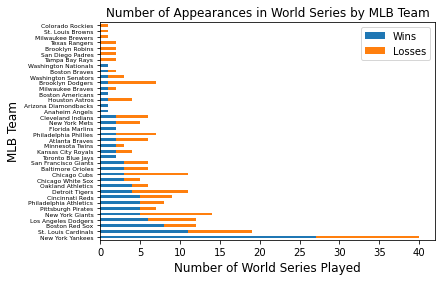

In [917]:
import folium
import pandas as pd
import json
from folium import plugins
import matplotlib.pyplot as plt

def visual1():
    wdict = pd.DataFrame(bargraph['Wins'].value_counts()).reset_index()
    ldict = pd.DataFrame(bargraph['Losses'].value_counts()).reset_index()
#     return ldict
    wdict = wdict.rename(columns={'index': 'Team'})
    ldict = ldict.rename(columns={'index':'Team'})
    new = pd.merge(wdict, ldict, on='Team', how='outer')
    new.reset_index()
    new = new.fillna(0)
    new.plot.barh(x='Team',stacked=True, title='Number of Appearances in World Series by MLB Team')
    plt.legend(loc='upper right')
    plt.xlabel('Number of World Series Played', fontsize=12)
    plt.ylabel('MLB Team', fontsize=12)
    SMALL_SIZE = 6
#     plt.rc('xtick', labelsize=SMALL_SIZE) 
    plt.rc('ytick', labelsize=SMALL_SIZE)  
    plt.savefig('Horizontal Bar.png')
    plt.show()




############ Function Call ############
visual1()

### Visualization 1 Explanation

The stacked bargraph above displays every team that has made it to the World Series along with number of appearances. The blue represents the appearances where they won the series, and the orange represents the appearances where the team lost. From this, it becomes clear which teams have the highest number of appearances in the World Series, along with the a visual displaying their Win/Lose ratio. You can notice that it seems there is a correlation between number of appearances and 50-50 Win/Lose Ratio. 

In [918]:
def visual2():
#     return dfedit

    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
    state_geo = f'{url}/us-states.json'

    with open('map.geojson') as f:
        us = json.load(f)

    usMap = folium.Map(location=[48, -102], zoom_start=3)

    folium.Choropleth(geo_data=state_geo,
        name='choropleth',
        data=statepop,
        columns=['state_id', 'population'],
        key_on='feature.id',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Population').add_to(usMap)

    for i,row in dfedit.iterrows():
        folium.CircleMarker((row.lat,row.lng),
                            radius=dfedit['population'][i]/700000, weight=1,
                            color='red', fill_color='red',
                            fill_opacity=.5).add_to(usMap)
    for i,row in nonmlbdf.iterrows():
        folium.CircleMarker((row.lat,row.lng),
                            radius=nonmlbdf['population'][i]/700000, weight=1,
                            color='blue', fill_color='blue',
                            fill_opacity=.5).add_to(usMap)    

    folium.LayerControl().add_to(usMap)
    display(usMap)
    usMap.save('usMap.html')

############ Function Call ############
print(visual2())

None


### Visualization 2 Explanation

Visual 2 displays popultions in the United States. The shade of the state relates to its population (as indicated in the legend in the top right). The radius of all circles are relative to one another in terms of city population. The red circle represent cities that are home to MLB Teams, while the blue circles represent cities without an MLB Team in the U.S. that still have a population over 400,000. This visual allows us to get a better understanding of the size of cities with MLB Teams for when we analyze if that is a factor into the team's success. 

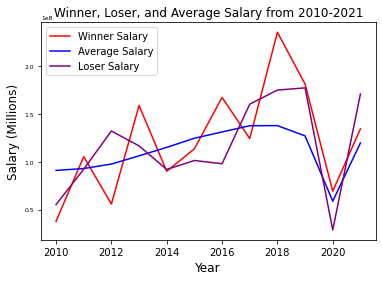

In [919]:
def visual3():
#     return compareavg

    ax1 = plt.gca()
    compareavg.plot(kind = 'line', x = 'Year', y = 'Winner Salary', color = 'red', ax = ax1)
    compareavg.plot(kind = 'line', x = 'Year', y = 'Average Salary', color = 'blue', ax = ax1)
    compareavg.plot(kind = 'line', x = 'Year', y = 'Loser Salary', color = 'purple', ax = ax1)
    plt.legend(loc='upper left')
    plt.title('Winner, Loser, and Average Salary from 2010-2021')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Salary (Millions)', fontsize=12)
    SMALL_SIZE = 10
    plt.rc('xtick', labelsize=SMALL_SIZE) 
    plt.rc('ytick', labelsize=SMALL_SIZE)


############ Function Call ############
compareavg = insight3()
# comparewinlose = insight4()
visual3()

### Visualization 3 Explanation

The visual above represents the average salary of all MLB teams from 2010-2021 along with the winner and loser salary in the World Series of the corresponding year. If there was a correlation here, the linegraph would show it, however, it does not seem to have an effect on MLB Teams on getting into and winning the World Series when it comes to salaries. 

## Summary Files

In [920]:
import numpy as np
import pandas as pd
import csv
import re 
import pprint as p
import json

def summary1():
    finaldicts = pd.DataFrame(finaldict)
    finaldicts = finaldicts.reset_index()
    finaldicts = finaldicts.rename(columns={'index': 'Team'})
#     return finaldicts
    newdict = pd.DataFrame()
    newl = []
    yearl = []
    winners = []
    losers = []
    
    final_dictz = pd.DataFrame()
    
    for y in range(2010,2022):
        newdict = finaldicts[y].dropna()
        newdict = newdict.replace('\D','',regex = True).astype(int)

        salaries = np.array(finaldicts[y])
        win_salary = 0;
        loser_salary = 0;
        average = int(newdict.mean())
        
        winner = bargraph['Wins'][y-1905]
        loser = bargraph['Losses'][y-1905]
        
        comp = winner.split()[0]
        loser_comp = loser.split()[0]
        for i, team in enumerate(finaldicts['Team']):
            if comp == team.split()[0] and str(salaries[i]).lower() != "nan":
                win_salary = salaries[i]               
            if team.split()[0][-1] == "*" and comp == team.split()[0][0:-1] and str(salaries[i]).lower() != "nan":
                win_salary = salaries[i]             
            if (team.split()[0][-1] == "*" and loser_comp == team.split()[0][0:-1] or loser_comp == team.split()[0]) and str(salaries[i]).lower() != "nan":
                loser_salary = salaries[i]           
            # New York Edge Case
            if team.split()[0] == "N.Y." and loser_comp == "New" and str(salaries[i]).lower() != "nan":
                loser_salary = salaries[i]        

        winnercity = winner.split()[0]
        losercity = loser.split()[0]
        wincitypop = 0
        losecitypop = 0
        
        for i, cities in enumerate(df2['city']):
            if winnercity == 'San':
                winnercity = 'San Francisco'
#                 wincitypop = df2['population'].iloc[i]
            if winnercity in cities: 
                wincitypop = df2['population'].iloc[i]
                
            if losercity == 'San':
                losercity = 'San Francisco'
#                 losecitypop = df2['population'].iloc[i]
            if losercity == 'Texas':
                losercity = 'Arlington'
            if losercity in cities: 
                losecitypop = df2['population'].iloc[i]
            
        
        final_dictz = final_dictz.append({'Year':str(y), 'Average Salary': average,
                                          'Winner': winner, "Winner Salary" : win_salary,
                                          'Winner City Population': wincitypop,
                                          'Loser':loser, 'Loser Salary': loser_salary, 'Loser City Population': losecitypop
                                          }, ignore_index=True)
        
    final_dictz["Winner Salary"] = final_dictz["Winner Salary"].replace('\D','',regex = True).astype(int)
    final_dictz["Loser Salary"] = final_dictz["Loser Salary"].replace('\D','',regex = True).astype(int)
    
    final_dictz["Winner Salary > Avg"] = final_dictz["Winner Salary"] > final_dictz["Average Salary"]
    final_dictz["Loser Salary > Avg "] = final_dictz["Loser Salary"] > final_dictz["Average Salary"]

    print(dfedit) #all mlb cities and info
    print(bargraph) #all mlb matchups w/ winner/loser
    print(final_dictz)

    #Exporting to Excel File
    writer = pd.ExcelWriter('Summary_File.xlsx', engine='xlsxwriter')

    final_dictz.to_excel(writer, sheet_name='2010-2021 Summary')
    dfedit.to_excel(writer, sheet_name='MLB Cities Population')
    bargraph.to_excel(writer, sheet_name='Matchups')
    estab_new.to_excel(writer, sheet_name = 'Team Summary')

    writer.save()
    return estab_new


############ Function Call ############
estab_new = insight5()
summary1()

Cactus Wins: 26.0
Cactus Total: 53.0
Grapefruit Wins: 67.0
Grapefruit Total: 120.0
              city state_id  population      lat       lng  density  \
0         New York       NY    18713220  40.6943  -73.9249    10715   
1      Los Angeles       CA    12750807  34.1139 -118.4068     3276   
2          Chicago       IL     8604203  41.8373  -87.6862     4574   
3            Miami       FL     6445545  25.7839  -80.2102     5019   
5     Philadelphia       PA     5649300  40.0077  -75.1339     4554   
6          Houston       TX     5464251  29.7863  -95.3889     1399   
7          Atlanta       GA     5449398  33.7627  -84.4224     1441   
8       Washington       DC     5379184  38.9047  -77.0163     4457   
9           Boston       MA     4688346  42.3188  -71.0846     5532   
10         Phoenix       AZ     4219697  33.5722 -112.0891     1253   
11         Seattle       WA     3789215  47.6211 -122.3244     3469   
12   San Francisco       CA     3592294  37.7562 -122.4430     72

,Team,Spring League,Wins,Losses,Total World Series,% Wins
0,Los Angeles Angels,Cactus League,0.0,0.0,0.0,0.0
1,Arizona Diamondbacks,Cactus League,0.0,0.0,0.0,0.0
2,Baltimore Orioles,Grapefruit League,3.0,3.0,6.0,50.0
3,Boston Red Sox,Grapefruit League,8.0,4.0,12.0,66.7
4,Chicago Cubs,Cactus League,3.0,8.0,11.0,27.3
5,Cincinnati Reds,Cactus League,5.0,4.0,9.0,55.6
6,Cleveland Guardians,Cactus League,0.0,0.0,0.0,0.0
7,Colorado Rockies,Cactus League,0.0,0.0,0.0,0.0
8,Detroit Tigers,Grapefruit League,4.0,7.0,11.0,36.4
9,Houston Astros,Grapefruit League,1.0,3.0,4.0,25.0


# Cited Sources

If you used any additional sources to complete your Data Analysis section, list them here:

https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
https://stackoverflow.com/questions/23415500/pandas-plotting-a-stacked-bar-chart 
https://python-visualization.github.io/folium/quickstart.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html


# Video Presentation

If you uploaded your Video Presentation to Bluejeans, YouTube, or any other streaming services, please provide the link here:


*   Video Presentation Link: https://youtu.be/qimaeBRCCmk 


Make sure the video sharing permissions are accessible for anyone with the provided link.